# Parallel Iterative Archetypal Analysis Functionalities Demonstration

**author:** Jonathan Yik Chang Ting

**email:** Jonathan.Ting@anu.edu.au

This is a notebook to demonstrate the functionalities provided by *archetypes.py* for the archetypal analysis of given datasets in an iterative manner. The code is developed based on the [code structure and functionalities for visualisation of the *archetypes.py* written by Benyamin Motevalli](https://researchdata.edu.au/archetypal-analysis-package/1424520), who in turn developed his code based on ["Archetypal Analysis" by Adele Cutler and Leo Breiman, Technometrics, November 1994, Vol.36, No.4, pp. 338-347](https://www.jstor.org/stable/1269949).

NOTE: This notebook contain cells that trigger job submissions to HPC clusters. Hence, running these cells might return some error messages (that would not impact the execution of the cells) if your machine is not a HPC or uses a different job scheduler (the current code only submits to PBS scheduler). However, the results from the job submissions have been included under `./data/subsetsOutputsPKLs/` so running the job submission cells are not essential.

## Import Packages

In [11]:
%load_ext autoreload
%autoreload 2

from os import chdir, getcwd
import pickle
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
import seaborn as sns
import sklearn
from sklearn.datasets import load_diabetes, make_blobs
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

chdir('/scratch/q27/jt5911/iterative-archetypal-analysis/iaa/docs')
import iaa
from iaa.piaa import ArchetypalAnalysis, subsetSplit, submitAAjobs, runAA, fitPIAA
from iaa.plot import createSimplexAx, mapAlfaToSimplex, plotRadarDatapoints, plotTSNE

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  iaa: {iaa.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Versions of imported libraries:
  iaa: 0.1.0
  matplotlib: 3.9.1
  numpy: 1.26.4
  pandas: 2.2.2
  scipy: 1.14.0
  seaborn: 0.13.2
  scikit-learn: 1.5.1


In [2]:
# Figure settings
# Variables specific for figures plotting
FIG_SIZE, DPI = (3.2, 4.5), None
CONT_PALETTE, QUAL_PALETTE = 'viridis', 'tab10'
sns.set_style('ticks')
# sns.set_palette(CONT_PALETTE)

SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('legend', title_fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

In [3]:
# General variables
RANDOM_STATE = 42
NUM_DIM_MANIFOLD = 2
VERBOSE = True
NUM_JOBS = 48

# Variables specific for splitting data into subsets
SHUFFLE = True  # Whether to shuffle data samples before splitting.

# Variables specific for archetypes.py functionalities
C = 0.0001  # constraint coefficient to ensure that the summation of alpha and beta equals to 1.

# Variables specific for the archetypal analysis algorithm provided by the SPArse Modeling Software (SPAMS) package
ROBUST = False  # Whether to use modified AA algorithm to deal with outliers
TOLERANCE = 0.001  # Threshold to decide when to stop optimisation.
COMPUTE_XTX = False  # Whether to compute X^T * X
STEPS_FISTA = 3  # Number of steps for fast iterative shrinkage-thresholding algorithm
STEPS_AS = 50  # Number of steps for active set algorithm
RANDOM_INIT = False  # Whether to initialise the archetypes randomly

# Directory paths
SUBSETS_PICKLES_PATH = "data/subsetsDataPKLs"
OUTPUTS_PICKLES_PATH = "data/subsetsOutputsPKLs"
FIGS_DIR_PATH = 'figs'
JOBSCRIPTS_DIR_PATH = "jobScripts"
AA_SCRIPT_PATH = '/scratch/q27/jt5911/iterative-archetypal-analysis/iaa/src/iaa/runAA.py'

# Set random seed
np.random.seed(RANDOM_STATE)

### Data Visualisation

For the visualisation of the (often high-dimensional) data, *t*-distributed stochastic neighbour embedding (*t*-SNE) is used.

#### Advantages
*t*-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student's *t*-distributions. This allows *t*-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:
- Revealing the structure at many scales on a single map.
- Revealing data that lie in multiple, different, manifolds or clusters.
- Reducing the tendency to crowd points together at the center.

#### Disadvantages
The disadvantages to using *t*-SNE are:
- *t*-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes.
- The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.
- The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.

#### Recommendations
*t*-SNE converts similarities between data points to joint probabilities and minimises the Kullback-Leibler (KL) divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. The KL divergence of the joint probabilities in the original space and the embedded space are minimised by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initialisations will end up in local minima of the KL divergence. Hence, it is useful to try different seeds and select the embedding with the lowest KL divergence.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. 

#### Why not UMAP?
Compared to uniform manifold approximation and projection (UMAP), *t*-SNE provides higher flexibility for the emphasis of local structures. While UMAP was thought to be superior in preserving global data structure, this was recently found to be attributed to the initialisation method (Users are directed to the [publication of Kobak and Linderman in 2021](https://doi.org/10.1038/nbt.4314) for further details). Consequently, *t*-SNE with informative initialisation (such as PCA initialisation) performs as well as UMAP in terms of preservation of global structure.

#### Why not other techniques?

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, *t*-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

#### Essential *t*-SNE Parameters

Parameters controlling the optimisation of *t*-SNE and therefore possibly the quality of the resulting embedding:
- **perplexity**: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value from [5, 50]. Different values can result in significantly different results. The perplexity must be less than the number of samples.
- **early_exaggeration**: Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.
- **learning_rate**: The learning rate for *t*-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help. The 'auto' option sets the learning_rate to $\text{max}(N / \text{early\_exaggeration} / 4, 50)$ where $N$ is the sample size, following the [work of Belkina et al.](https://doi.org/10.1038/s41467-019-13055-y) and the [work of Kobak and Berens](https://doi.org/10.1038/s41467-019-13056-x).
- **n_iter**: Maximum number of iterations for the optimization. Should be at least 250.
- **angle**: Angular size (referred to as theta in the [work of van der Maaten](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf)) of a distant node as measured from a point. If this size is below 'angle' then it is used as a summary node of all points contained within it. This method is not very sensitive to changes in this parameter in the range of [0.2, 0.8]. Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error. Only used if **method**='barnes_hut' This is the trade-off between speed and accuracy for Barnes-Hut *t*-SNE. 

Other Parameters:
- **n_components**: Dimension of the embedded space.
- **min_grad_norm**: If the gradient norm is below this threshold, the optimization will be stopped.
- **metric**: The metric to use when calculating distance between instances in a feature array. The default is “euclidean” which is interpreted as squared euclidean distance.
- **init**: Initialisation of embedding. PCA initialisation cannot be used with precomputed distances and is usually more globally stable than random initialisation.
- **method**: By default the gradient calculation algorithm uses Barnes-Hut approximation running in $O(N\text{log}N)$ time. The 'exact' option will run on the slower, but exact, algorithm in $O(N^2)$ time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

The effects of changing the parameters of *t*-SNE can be understood from [some experiments visualised](https://distill.pub/2016/misread-tsne/)!

## Reference vs Parallel Iterative Archetypal Analysis

We will first use a few two-dimensional datasets to allow visual comparisons between the reference and parallel iterative approaches to archetypal analysis of a given dataset.

### Arguments Description
- **nArchetypes**: Defines how many archetypes will be extracted. A positive integer. Setting to 1 return the mean of the data set. *Default = 2*.
- **iterative**: Whether to use the iterative or reference approach. *Default = False*.
- **nSubsets**: The number of subsets to split the data into if **iterative** = True. *Default = 10*.
- **shuffle**: Whether to shuffle the data samples before splitting. *Default = True*.
- **onlyZ**: Whether to stop running when archetypes are computed. Setting to True allows only archetypes and run time to be returned. *Default = False*.
- **C**: the weight on the constraint equation. Inversely proportional to the strength of constraint. *Default = 0.0001*. Constraint Equation: $$\sum\alpha = 1,$$ $$\sum\beta = 1$$

The following arguments are specific to the archetypal analysis algorithm provided by the [SPArse Modeling Software (SPAMS) package](https://thoth.inrialpes.fr/people/mairal/spams/), hence Users are directed to their homepage and the original publication describing the algorithm in "[Fast and Robust Archetypal Analysis for Representation Learning](https://ieeexplore.ieee.org/document/6909588)" for up-to-date and detailed descriptions.
- **robust**
- **tolerance**
- **computeXtX**
- **stepsFISTA**
- **stepsAS**
- **randominit**
- **random_state**
- **numThreads**

### General Functions

In [4]:
def plotFirst2D(X, figNamePrefix='', figSize=(3, 3), markerSize=1, numComponents=2, markIdxs=[]):
    plt.figure(figsize=figSize)
    plt.scatter(X[:, 0], X[:, 1], s=markerSize, c='k') # c=range(len(X)), cmap=CONT_PALETTE)
    plt.scatter(x=X[markIdxs, 0], y=X[markIdxs, 1], 
                marker='D', s=markerSize*30, facecolor='r', edgecolor='k', linewidth=0.8)
    plt.grid(linestyle='dotted')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if len(markIdxs) > 0:
        plt.legend(['Sample', 'Most archetypal sample'], bbox_to_anchor=[0.5, -0.35], loc='center')
    plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_data.png", bbox_inches='tight')

In [5]:
def plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=True, figNamePrefix='',
                  figSize=(7, 4), dpi=300, verbose=False):
    """Plot the data and archetypes from both approaches."""
    Zreference, Ziterative = AAreference.archetypes, AAiterative.archetypes
    sns.set_palette(QUAL_PALETTE)
    plt.figure(figsize=figSize, dpi=dpi)
    if not plotSubsets:
        plt.scatter(Xscaled[:, 0], Xscaled[:, 1], marker='.', s=5) # color='y', 
    else:
        for idxs in AAiterative.subsetsSampleIdxs: 
            plt.scatter(Xscaled[idxs, 0], Xscaled[idxs, 1], marker='.', s=5)
    allSubsetsZs =  np.concatenate(AAiterative.subsetsZs, axis=1)
    plt.plot(allSubsetsZs[0, :], allSubsetsZs[1, :], 'D', markersize=6, markeredgecolor='k', markeredgewidth=0.6, color='y')  # color='b'
    plt.plot(Zreference[0, :], Zreference[1, :], 'X', markersize=12, markeredgecolor='k', markeredgewidth=0.8, color='r', alpha=0.7)  # color='m'
    plt.plot(Ziterative[0, :], Ziterative[1, :], 'X', markersize=12, markeredgecolor='k', markeredgewidth=0.8, color='b', alpha=0.7)  # color='c'
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(linestyle='dotted')
    legendEntries = [f"Data Subset {i+1}" for i in range(len(AAiterative.subsetsSampleIdxs))] if plotSubsets else ['Data']
    # legendEntries += ['Archetypes from Split Sets', f"Reference Approach Archetypes, ExpVar: {AAreference.explainedVariance_:.3f}", f"Iterative Approach Archetypes, ExpVar: {AAiterative.explainedVariance_:.3f}"]
    legendEntries += ['Archetypes from Split Sets', 'Reference Approach Archetypes', 'Iterative Approach Archetypes',]
    # plt.legend(legendEntries, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=False, fontsize='x-small')
    plt.legend(legendEntries, loc='center', bbox_to_anchor=(0.5, -0.5), ncol=1, fancybox=True, shadow=False, fontsize='small')
    plt.tight_layout()
    plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}.png")

# runAAonData(Xscaled, AAreference, AAiterative,
#             datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=(3.2, 4.5), dpi=DPI, verbose=VERBOSE)

In [6]:
def runRAA(Xscaled, numArchetypes=4, robust=False, onlyZ=False, randomState=42, verbose=False):
    AAreference = ArchetypalAnalysis(nArchetypes=numArchetypes, iterative=False, robust=robust, onlyZ=onlyZ,
                                     C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                     randomState=randomState, numThreads=NUM_JOBS)
    AAreference.fit(Xscaled)
    if verbose:
        print(f"Reference archetypal analysis execution time: {AAreference.runTime:.3f} s")
        print(f"Explained variance: {AAreference.explainedVariance_:.3f}\n")
    return AAreference

In [31]:
def runPIAA1(Xscaled, numArchetypes=4, numSubset=4, shuffle=True, randomState=42, datasetType='uniformSquare', 
             project='q27', queue='normal', numCPUs=48, wallTime='01:00:00', mem=190, jobFS=100, 
             email='Jonathan.Ting@anu.edu.au', verbose=False):
    splitRunTime = subsetSplit(Xscaled, nSubsets=numSubset, dataName=datasetType, subsetsPicklesPath=SUBSETS_PICKLES_PATH,
                               shuffle=shuffle, randomState=randomState, verbose=verbose)
    # submitAAjobs(nArchetypes=numArchetypes, dataName=datasetType, splitKeyword='data',
    #              jobscriptsDirPath=JOBSCRIPTS_DIR_PATH, 
    #              subsetsPicklesPath=SUBSETS_PICKLES_PATH, 
    #              outputsPicklesPath=OUTPUTS_PICKLES_PATH, 
    #              AAscriptPath=AA_SCRIPT_PATH,
    #              project=project, queue=queue, numCPUs=numCPUs, wallTime=wallTime, mem=mem, jobFS=jobFS, email=email,
    #              verbose=verbose)
    return splitRunTime

In [8]:
def runPIAA2(Xscaled, numArchetypes=4, numSubset=4, onlyZ=False,
             robust=False, shuffle=True, randomState=RANDOM_STATE, 
             datasetType='uniformSquare', verbose=False, splitRunTime=0.0):
    AAiterative = fitPIAA(Xscaled, nArchetypes=numArchetypes, numSubset=numSubset, 
                          dataName=datasetType, outputsPicklesPath=OUTPUTS_PICKLES_PATH, 
                          shuffle=shuffle, robust=robust, onlyZ=onlyZ, C=0.0001, tolerance=TOLERANCE, 
                          computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                          randomState=randomState, numThreads=NUM_JOBS, splitRunTime=splitRunTime, verbose=verbose)
    if verbose:
        print(f"Parallel iterative archetypal analysis {numSubset} subsets execution time: {AAiterative.runTime:.3f} s\n")
    return AAiterative

In [9]:
def runAAonData(Xscaled, AAreference, AAiterative,
                datasetType='uniformSquare', plotSubsets=True, figSize=(7, 4), dpi=300, verbose=False):
    colourSubsetsStr = 'colourSubsets' if plotSubsets else 'colourWholeSet'
    plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=plotSubsets, figNamePrefix=f"{datasetType}_{numSubset}-fold_{colourSubsetsStr}",
                  figSize=figSize, dpi=dpi, verbose=verbose)

### Uniform Square

#### Load Data

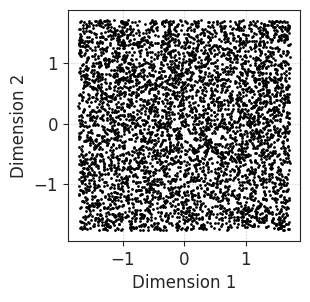

In [12]:
# Generate data
NUM_SAMPLES = 5000
figNamePrefix = 'uniformSquarePIAA'
x = np.random.uniform(-10, 10, NUM_SAMPLES)
y = np.random.uniform(-10, 10, NUM_SAMPLES)
X = np.array([[xi, yi] for xi, yi in zip(x, y)])

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Visualise data
plotFirst2D(Xscaled, figNamePrefix=figNamePrefix)  # First two dimensions
# plotTSNE(Xscaled, figNamePrefix=figNamePrefix, perplexity=100)  # Manifold learning

#### Extracting Archetypes

Here we extract the *4* archetypes from the dataset. For the iterative approach we also compare the results when we split the original dataset into *2*, *4*, and *8* subsets.

##### 2 Subsets

In [29]:
numArchetypes, numSubset = 4, 2

# Run the reference archetypal analysis for comparison with the parallel iterative approach
AAreference = runRAA(Xscaled, numArchetypes=numArchetypes, robust=ROBUST, onlyZ=False, randomState=RANDOM_STATE, verbose=VERBOSE)

RSS FISTA = 1880.8073
RSS FISTA = 974.85341
RSS FISTA = 823.91882
RSS AS = 686.06549
RSS AS = 665.15054
RSS AS = 656.03427
RSS AS = 647.55427
RSS AS = 638.83175
RSS AS = 628.65223
RSS AS = 615.13788
RSS AS = 595.65144
RSS AS = 566.56385
RSS AS = 523.45676
RSS AS = 463.04391
RSS AS = 386.84152
RSS AS = 303.18151
RSS AS = 223.92279
RSS AS = 158.39149
RSS AS = 109.66837
RSS AS = 76.221137
RSS AS = 53.534953
RSS AS = 38.191202
RSS AS = 27.796647
RSS AS = 20.684801
RSS AS = 15.71484
RSS AS = 12.153555
RSS AS = 9.5532331
RSS AS = 7.6423764
RSS AS = 6.2131776
RSS AS = 5.1168369
RSS AS = 4.2636321
RSS AS = 3.5933666
RSS AS = 3.0579378
RSS AS = 2.6254252
RSS AS = 2.2719343
RSS AS = 1.9802476
RSS AS = 1.7380078
RSS AS = 1.5354565
RSS AS = 1.3650926
RSS AS = 1.2202526
RSS AS = 1.0958159
RSS AS = 0.9881261
RSS AS = 0.89441293
RSS AS = 0.81245359
RSS AS = 0.74021785
RSS AS = 0.67618351
RSS AS = 0.61952813
RSS AS = 0.56934861
RSS AS = 0.52493547
RSS AS = 0.48754935
RSS AS = 0.45146994
RSS AS = 0.418

In [30]:
# Split the data into subsets and run archetypal analysis on each subset (NOTE: job submission could only be done on HPC clusters)
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{figNamePrefix}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 2 subsets...
  Subset 1
  Subset 2
Time spent on subset-splitting: 0.040 s


In [34]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: uniformSquarePIAA2Soutput1.pkl
: 0.6264450550079346 s
  Subset: uniformSquarePIAA2Soutput2.pkl
: 0.6129827499389648 s
RSS FISTA = 0.0068938478
RSS FISTA = 0.0036517128
RSS FISTA = 0.0036526515
RSS AS = 0.0025685998
RSS AS = 0.0017760152
RSS AS = 0.0015868492
RSS AS = 0.0015424039
RSS AS = 0.0015320722
RSS AS = 0.0015296742
RSS AS = 0.0015291178
RSS AS = 0.0015290038
RSS AS = 0.0015289936
RSS AS = 0.0015289915
RSS AS = 0.001528991
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS = 0.0015289909
RSS AS

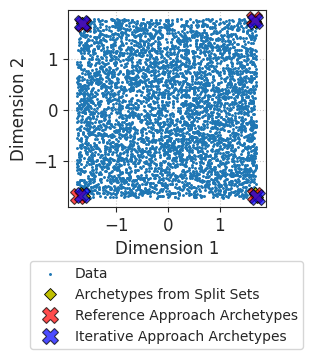

In [103]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 4 Subsets

In [23]:
numArchetypes, numSubset = 4, 4
# Split the data into subsets and run archetypal analysis on each subset (NOTE: job submission could only be done on HPC clusters)
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{figNamePrefix}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 4 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
Time spent on subset-splitting: 0.004 s


In [27]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: uniformSquarePIAA4Soutput1.pkl
: 0.3778669834136963 s
  Subset: uniformSquarePIAA4Soutput2.pkl
: 0.39263057708740234 s
  Subset: uniformSquarePIAA4Soutput3.pkl
: 0.3770925998687744 s
  Subset: uniformSquarePIAA4Soutput4.pkl
: 0.3926279544830322 s
RSS FISTA = 0.035333916
RSS FISTA = 0.013786665
RSS FISTA = 0.013752166
RSS AS = 0.0078387483
RSS AS = 0.0041820527
RSS AS = 0.0032269266
RSS AS = 0.0028424135
RSS AS = 0.0027107123
RSS AS = 0.0026757027
RSS AS = 0.0026568686
RSS AS = 0.0026465319
RSS AS = 0.0026408554
RSS AS = 0.0026377375
RSS AS = 0.0026360248
RSS AS = 0.002635084
RSS AS = 0.0026345672
RSS AS = 0.0026342833
RSS AS = 0.0026341273
RSS AS = 0.0026340416
RSS AS = 0.0026339946
RSS AS = 0.0026339687
RSS AS = 0.0026339545
RSS AS = 0.0026339467
RSS AS = 0.0026339424
RSS AS = 0.00263394
RSS AS = 0.0026339387
RSS AS = 0.002633938
RSS AS = 0.0026339376
RSS AS = 0.0026339374
RSS AS = 0.0026339373
RSS AS = 0.0026339372
RSS AS = 0.0026339372
RSS AS = 0.0026339372
RSS AS = 0.0026

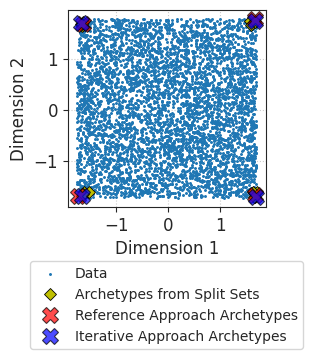

In [106]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 8 Subsets

In [19]:
numSubset = 8
# Split the data into subsets and run archetypal analysis on each subset (NOTE: job submission could only be done on HPC clusters)
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{figNamePrefix}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 8 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
  Subset 5
  Subset 6
  Subset 7
  Subset 8
Time spent on subset-splitting: 0.131 s


In [24]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: uniformSquarePIAA8Soutput1.pkl
: 0.16580748558044434 s
  Subset: uniformSquarePIAA8Soutput2.pkl
: 0.16795969009399414 s
  Subset: uniformSquarePIAA8Soutput3.pkl
: 0.15764427185058594 s
  Subset: uniformSquarePIAA8Soutput4.pkl
: 0.16362428665161133 s
  Subset: uniformSquarePIAA8Soutput5.pkl
: 0.16362380981445312 s
  Subset: uniformSquarePIAA8Soutput6.pkl
: 0.16123485565185547 s
  Subset: uniformSquarePIAA8Soutput7.pkl
: 0.1612393856048584 s
  Subset: uniformSquarePIAA8Soutput8.pkl
: 0.15633130073547363 s
RSS FISTA = 0.1397652
RSS FISTA = 0.071913434
RSS FISTA = 0.071725165
RSS AS = 0.040367953
RSS AS = 0.018009897
RSS AS = 0.010223282
RSS AS = 0.0064366137
RSS AS = 0.0044912148
RSS AS = 0.0034703879
RSS AS = 0.0029344112
RSS AS = 0.0026160871
RSS AS = 0.0024116076
RSS AS = 0.0022754258
RSS AS = 0.002181155
RSS AS = 0.0021126768
RSS AS = 0.0020624965
RSS AS = 0.0020256389
RSS AS = 0.0019985081
RSS AS = 0.0019784974
RSS AS = 0.001963711
RSS AS = 0.0019527666
RSS AS = 0.001944653

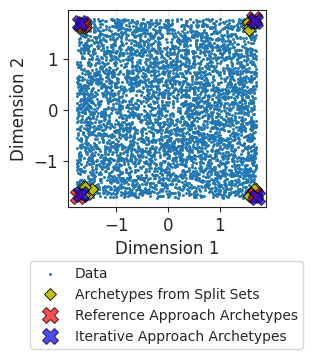

In [109]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

It could be seen that the final archetypes from both approaches lie very close to each other in the two-dimensional feature space, and the explained variances are both very high.

#### Visualising Most Archetypal Samples

Here we mark out the most archetypal samples in the data.

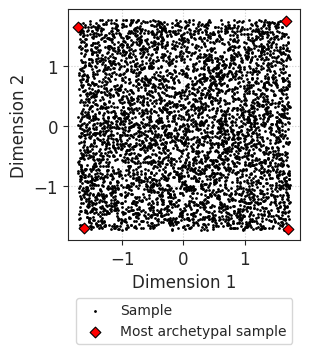

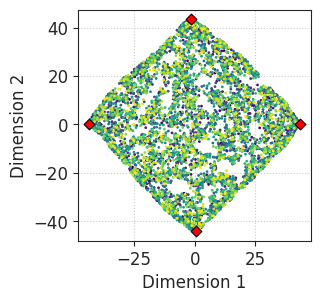

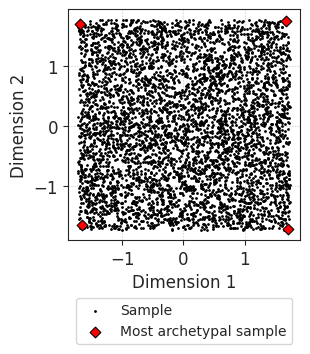

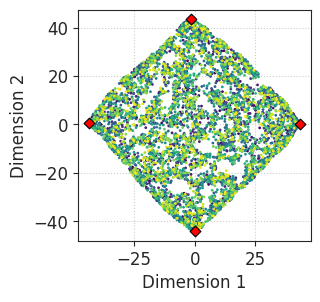

In [49]:
# Reference archetypal analysis
AAreference._extractCloseMatch()
closestSampleIdxsRAA = [sampleIdx for (sampleIdx, archetype) in AAreference.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", markIdxs=closestSampleIdxsRAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", perplexity=100, markIdxs=closestSampleIdxsRAA)

# Iterative archetypal analysis
AAiterative._extractCloseMatch()
closestSampleIdxsIAA = [sampleIdx for (sampleIdx, archetype) in AAiterative.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", markIdxs=closestSampleIdxsIAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", perplexity=100, markIdxs=closestSampleIdxsIAA)

### Blob

#### Load Data

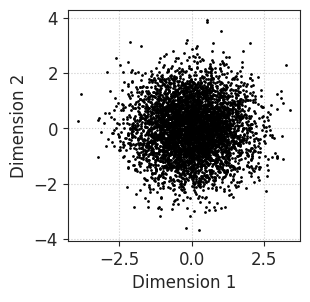

In [29]:
# Generate data
NUM_SAMPLES = 5000
figNamePrefix = 'blobPIAA'
X, y_true = make_blobs(n_samples=NUM_SAMPLES, centers=1, cluster_std=30, random_state=RANDOM_STATE)

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Visualise data 
plotFirst2D(Xscaled, figNamePrefix=figNamePrefix)  # First two dimensions
# plotTSNE(Xscaled, figNamePrefix=figNamePrefix, perplexity=100)  # Manifold learning

#### Extracting Archetypes

Here we extract the *8* archetypes from the dataset. For the iterative approach we also compare the results when we split the original dataset into *2*, *4*, and *8* subsets.

##### 2 Subsets

In [91]:
numArchetypes, numSubset = 8, 2

# Run the reference archetypal analysis for comparison with the parallel iterative approach
AAreference = runRAA(Xscaled, numArchetypes=numArchetypes, robust=ROBUST, onlyZ=False, randomState=RANDOM_STATE, verbose=VERBOSE)

RSS FISTA = 567.92629
RSS FISTA = 343.48194
RSS FISTA = 242.36925
RSS AS = 187.7501
RSS AS = 39.155824
RSS AS = 11.869986
RSS AS = 9.1948607
RSS AS = 7.4845863
RSS AS = 6.2927065
RSS AS = 5.4094798
RSS AS = 4.7313219
RSS AS = 4.2040976
RSS AS = 3.789576
RSS AS = 3.4636181
RSS AS = 3.1919106
RSS AS = 2.9622292
RSS AS = 2.7680201
RSS AS = 2.6018929
RSS AS = 2.4543572
RSS AS = 2.322043
RSS AS = 2.2069817
RSS AS = 2.1104737
RSS AS = 2.0218
RSS AS = 1.9396115
RSS AS = 1.862701
RSS AS = 1.79057
RSS AS = 1.7229683
RSS AS = 1.6597277
RSS AS = 1.6158841
RSS AS = 1.5874731
RSS AS = 1.560214
RSS AS = 1.5340444
RSS AS = 1.5088578
RSS AS = 1.4845801
RSS AS = 1.4611587
RSS AS = 1.4385509
RSS AS = 1.4166832
RSS AS = 1.3955227
RSS AS = 1.375033
RSS AS = 1.3552359
RSS AS = 1.3360839
RSS AS = 1.3175375
RSS AS = 1.2995756
RSS AS = 1.2821905
RSS AS = 1.2653439
RSS AS = 1.249027
RSS AS = 1.2331995
RSS AS = 1.2178197
RSS AS = 1.2028844
RSS AS = 1.188368
RSS AS = 1.1742572
RSS AS = 1.1605453
RSS AS = 1.14720

In [47]:
# Split the data into subsets and run archetypal analysis on each subset (NOTE: job submission could only be done on HPC clusters)
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{figNamePrefix}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 2 subsets...
  Subset 1
  Subset 2
Time spent on subset-splitting: 0.016 s


In [55]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: blobPIAA2Soutput1.pkl
: 0.9003973007202148 s
  Subset: blobPIAA2Soutput2.pkl
: 2.076582908630371 s
RSS FISTA = 2.100786
RSS FISTA = 1.833106
RSS FISTA = 1.5590395
RSS AS = 1.1852325
RSS AS = 0.96168327
RSS AS = 0.77829578
RSS AS = 0.61874368
RSS AS = 0.48618941
RSS AS = 0.38215439
RSS AS = 0.30713462
RSS AS = 0.25752616
RSS AS = 0.22619726
RSS AS = 0.20619376
RSS AS = 0.19286438
RSS AS = 0.18365102
RSS AS = 0.17718994
RSS AS = 0.17267355
RSS AS = 0.16955239
RSS AS = 0.16742257
RSS AS = 0.16598376
RSS AS = 0.16501728
RSS AS = 0.16436847
RSS AS = 0.16392803
RSS AS = 0.1636225
RSS AS = 0.16340966
RSS AS = 0.16326025
RSS AS = 0.16315427
RSS AS = 0.16307824
RSS AS = 0.16302298
RSS AS = 0.16298233
RSS AS = 0.1629521
RSS AS = 0.16292941
RSS AS = 0.16291224
RSS AS = 0.16289917
RSS AS = 0.16288917
RSS AS = 0.16288148
RSS AS = 0.16287556
RSS AS = 0.16287099
RSS AS = 0.16286745
RSS AS = 0.16286472
RSS AS = 0.1628626
RSS AS = 0.16286095
RSS AS = 0.16285968
RSS AS = 0.16285869
RSS AS = 0.

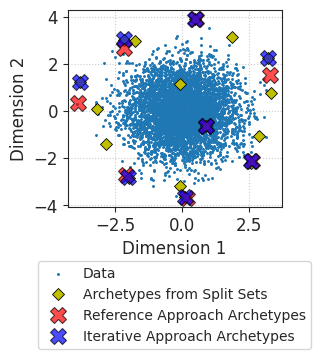

In [114]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 4 Subsets

In [33]:
numSubset = 4
# Split the data into subsets and run archetypal analysis on each subset (NOTE: job submission could only be done on HPC clusters)
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{figNamePrefix}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 4 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
Time spent on subset-splitting: 0.004 s


In [38]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: blobPIAA4Soutput1.pkl
: 0.3368980884552002 s
  Subset: blobPIAA4Soutput2.pkl
: 0.3237118721008301 s
  Subset: blobPIAA4Soutput3.pkl
: 0.29695868492126465 s
  Subset: blobPIAA4Soutput4.pkl
: 0.32176923751831055 s
RSS FISTA = 5.830178
RSS FISTA = 3.8254679
RSS FISTA = 3.2511182
RSS AS = 2.9670884
RSS AS = 2.8770631
RSS AS = 2.8274403
RSS AS = 2.7994535
RSS AS = 2.7825354
RSS AS = 2.7716244
RSS AS = 2.7647161
RSS AS = 2.7614149
RSS AS = 2.7595023
RSS AS = 2.7583337
RSS AS = 2.7576069
RSS AS = 2.757151
RSS AS = 2.7568635
RSS AS = 2.7566816
RSS AS = 2.7565664
RSS AS = 2.7564933
RSS AS = 2.7564468
RSS AS = 2.7564173
RSS AS = 2.7563985
RSS AS = 2.7563865
RSS AS = 2.7563789
RSS AS = 2.756374
RSS AS = 2.7563709
RSS AS = 2.7563689
RSS AS = 2.7563677
RSS AS = 2.7563668
RSS AS = 2.7563663
RSS AS = 2.756366
RSS AS = 2.7563658
RSS AS = 2.7563657
RSS AS = 2.7563656
RSS AS = 2.7563655
RSS AS = 2.7563655
RSS AS = 2.7563655
RSS AS = 2.7563654
RSS AS = 2.7563654
RSS AS = 2.7563654
RSS AS = 2.75

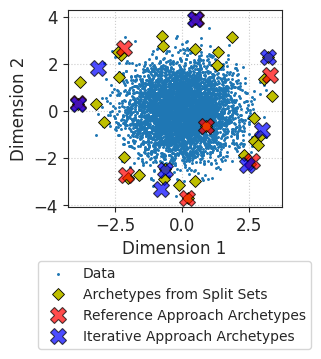

In [117]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

##### 8 Subsets

In [64]:
numSubset = 8
# Split the data into subsets and run archetypal analysis on each subset (NOTE: job submission could only be done on HPC clusters)
splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                        datasetType=f"{figNamePrefix}{numSubset}S", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 8 subsets...
  Subset 1
  Subset 2
  Subset 3
  Subset 4
  Subset 5
  Subset 6
  Subset 7
  Subset 8
Time spent on subset-splitting: 0.153 s


In [69]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AAiterative = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                       robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                       datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: blobPIAA8Soutput1.pkl
: 0.19180011749267578 s
  Subset: blobPIAA8Soutput2.pkl
: 0.20184111595153809 s
  Subset: blobPIAA8Soutput3.pkl
: 0.22078919410705566 s
  Subset: blobPIAA8Soutput4.pkl
: 0.19807696342468262 s
  Subset: blobPIAA8Soutput5.pkl
: 0.21799135208129883 s
  Subset: blobPIAA8Soutput6.pkl
: 0.20346355438232422 s
  Subset: blobPIAA8Soutput7.pkl
: 0.20819568634033203 s
  Subset: blobPIAA8Soutput8.pkl
: 0.19992613792419434 s
RSS FISTA = 5.8764286
RSS FISTA = 3.0168804
RSS FISTA = 2.2432682
RSS AS = 1.3450534
RSS AS = 0.79816069
RSS AS = 0.5974334
RSS AS = 0.47710306
RSS AS = 0.407699
RSS AS = 0.36681489
RSS AS = 0.33926065
RSS AS = 0.32016076
RSS AS = 0.3060408
RSS AS = 0.29525552
RSS AS = 0.28675343
RSS AS = 0.28018697
RSS AS = 0.27453046
RSS AS = 0.26960171
RSS AS = 0.26554362
RSS AS = 0.26200797
RSS AS = 0.25876601
RSS AS = 0.25579485
RSS AS = 0.25307338
RSS AS = 0.25065005
RSS AS = 0.24848211
RSS AS = 0.24652893
RSS AS = 0.24477508
RSS AS = 0.24316538
RSS AS = 0.

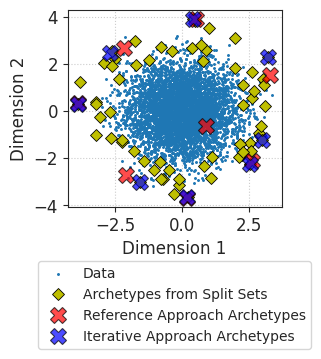

In [85]:
# Compare the parallel iterative approach with the reference approach
runAAonData(Xscaled, AAreference, AAiterative,
            datasetType=f"{figNamePrefix}{numSubset}S", plotSubsets=False, figSize=FIG_SIZE, dpi=DPI, verbose=VERBOSE)

#### Visualising Most Archetypal Samples

Here we mark out the most archetypal samples in the data.

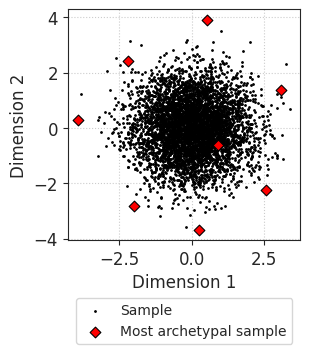

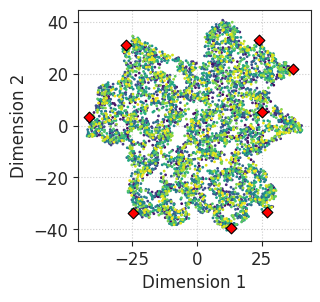

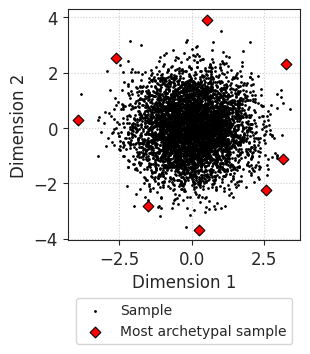

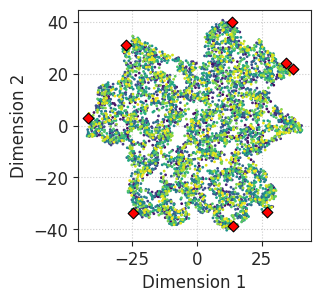

In [63]:
# Reference archetypal analysis
AAreference._extractCloseMatch()
closestSampleIdxsRAA = [sampleIdx for (sampleIdx, archetype) in AAreference.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", markIdxs=closestSampleIdxsRAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_rAA", perplexity=100, markIdxs=closestSampleIdxsRAA)

# Iterative archetypal analysis
AAiterative._extractCloseMatch()
closestSampleIdxsIAA = [sampleIdx for (sampleIdx, archetype) in AAiterative.closeMatch.values()]
plotFirst2D(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", markIdxs=closestSampleIdxsIAA)
plotTSNE(Xscaled, figNamePrefix=f"{figNamePrefix}_iAA", perplexity=100, markIdxs=closestSampleIdxsIAA)

While the locations of the final archetypes from both approaches do not overlap very much with each other in the two-dimensional feature space for this dataset, the explained variances are both very high.

## Functionalities Demonstration

From here onwards we will demonstrate the functionalities provided by *archetypes.py*.

The following functionalities are covered:
- extraction of the archetype attributes, 
- mapping of data to the archetype space,
- visualisation of archetype profiles (contributions of the archetypes in describing any other data sample), 
- identification of the most archetypal data samples, 
- visualisation of the data samples and archetypes on parallel axis.

### Load Data

The skeleton dataset will be used for the following demonstration to allow comparison with previous methods. 

The dataset:
- is a real world dataset used for demonstration in [From Spider-Man to Hero -- Archetypal Analysis in R](https://www.jstatsoft.org/article/view/v030i08). 
- was collected by Heinz G et al. in [Exploring Relationships in Body Dimensions](http://www.amstat.org/publications/jse/v11n2/datasets.heinz.html).
- includes 507 samples, of which 247 are men and 260 are women.
- has 25 features, but only 11 were used in [From Spider-Man to Hero -- Archetypal Analysis in R](https://www.jstatsoft.org/article/view/v030i08).

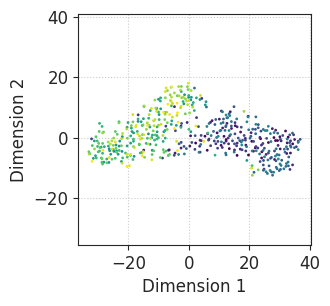

In [20]:
# Load the data
r = requests.get('http://jse.amstat.org/datasets/body.dat.txt')
data = np.array(list(map(lambda x: list(map(float, x.split())), r.text.splitlines())))
figNamePrefix = 'skeletonPIAA'

# Order the columns in the similar order that appears in previous studies.
columns = ['AnkleDiam', 'KneeDiam', 'WristDiam', 'Bitro', 'Biil', 'ElbowDiam', 'ChestDiam', 'ChestDp', 'Biac', 'Height', 'Gender']
selectedCols = [8, 7, 6, 2, 1, 5, 4, 3, 0, 23, 24]
df = pd.DataFrame(data[:, selectedCols], columns=columns)

# Map the entries in the gender column into strings
gender = {1.0: 'male', 0.0: 'female'}
df['Gender'] = df.apply(lambda row: gender[row['Gender']], axis = 1)

# Generate the feature set
featNames = ['AnkleDiam', 'KneeDiam', 'WristDiam', 'Bitro', 'Biil', 'ElbowDiam', 'ChestDiam', 'ChestDp', 'Biac', 'Height']
X = df[featNames].values

# Standardise all features
sc = StandardScaler()
Xscaled = sc.fit_transform(X)

# Data visualisation
plotTSNE(Xscaled, figNamePrefix=figNamePrefix, perplexity=30)

### Extracting Attributes from Archetypal Analysis Object

Once the **ArchetypalAnalysis()** object was fitted to the data, we can extract a few outputs from it. 

Below is a list of the attributes that could be extracted. Note that $n$, $m$, and $k$ refers to the number of samples, number of features, and number of archetypes, respectively:
- **.archetypes** returns $Z$ (with a shape of $(m \times k)$), the computed archetypes.
- **.alfa** returns $A$ (with a shape of $(k \times n)$), the coefficient matrix to multiply to $Z$ to approximately reconstruct $X$.
- **.beta** returns $B$ (with a shape of $(n \times k)$), the coefficient matrix to multiply to $X$ to obtain $Z$.
- **.X** returns $X^T$ (with a shape of $(m \times n)$), the transposed original data.
- **.X_approx** returns $X_{\text{approx}}$ (with a shape of $(m \times n)$), the reconstructed data.
- **.explainedVariance_** tells how close is $X_{\text{approx}}$ to $X$. It is computed using *explained_variance_score()* from the *sklearn* package.
- **.archetype_profile** provides the profile of the archetypes (with a shape of $(m \times n)$). It shows the fraction of importance of each feature for each archetype (which sums to 1.0).
- **.closeMatch** contains the most archetypal data points. It is only computed after **._extractCloseMatch()** is run.
- **.runTime** returns the execution duration (s) of the algorithm for $Z$ to be computed.

The following outputs are only useful when *iterative* is set to *True*:
- **.subsets_sample_idxs** returns the indices of the samples for each data subset.
- **.subsets_Zs** returns the archetypes obtained from each data subset.

In [32]:
numArchetypes, numSubset = 10, 3
# Split the data into subsets and run archetypal analysis on each subset
splitRunTime = runPIAA1(Xscaled, numArchetypes, numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, datasetType=f"{figNamePrefix}{numSubset}S", 
               project='q27', queue='normal', numCPUs=1, wallTime='00:03:00', mem=5, jobFS=1, email='Jonathan.Ting@anu.edu.au', 
               verbose=VERBOSE)

Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Generating archetypal analysis HPC jobs for all subsets...
119756901.gadi-pbs
  Submitted job for skeletonPIAA3Sdata3.pkl...
119756902.gadi-pbs
  Submitted job for skeletonPIAA3Sdata1.pkl...
119756903.gadi-pbs
  Submitted job for skeletonPIAA3Sdata2.pkl...
All jobs submitted!


In [33]:
# Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
AA = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
              robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
              datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: skeletonPIAA3Soutput1.pkl
  Subset: skeletonPIAA3Soutput2.pkl
  Subset: skeletonPIAA3Soutput3.pkl
RSS FISTA = 59.189918
RSS FISTA = 56.836108
RSS FISTA = 56.116785
RSS AS = 55.409545
RSS AS = 55.170305
RSS AS = 54.957266
RSS AS = 54.644025
RSS AS = 54.093253
RSS AS = 53.329811
RSS AS = 52.619569
RSS AS = 52.053813
RSS AS = 51.608036
RSS AS = 51.074149
RSS AS = 50.231967
RSS AS = 48.802196
RSS AS = 47.078227
RSS AS = 46.05157
RSS AS = 45.756935
RSS AS = 45.699881
RSS AS = 45.681891
RSS AS = 45.671222
RSS AS = 45.661799
RSS AS = 45.651464
RSS AS = 45.639292
RSS AS = 45.624602
RSS AS = 45.606694
RSS AS = 45.584753
RSS AS = 45.557827
RSS AS = 45.526152
RSS AS = 45.491821
RSS AS = 45.453535
RSS AS = 45.411059
RSS AS = 45.364487
RSS AS = 45.314087
RSS AS = 45.262822
RSS AS = 45.220928
RSS AS = 45.186327
RSS AS = 45.158372
RSS AS = 45.136703
RSS AS = 45.120641
RSS AS = 45.10924
RSS AS = 45.101466
RSS AS = 45.096417
RSS AS = 45.093574
RSS AS = 45.092032
RSS AS = 45.091189
RSS AS = 45

In [74]:
print(f"Z:\n{AA.archetypes}\n")
print(f"A:\n{AA.alfa}\n")
print(f"B:\n{AA.beta}\n")
print(f"X:\n{AA.X}\n")
print(f"Approximately reconstructed X:\n{AA.Xapprox}\n")
print(f"Explained variance:\n{AA.explainedVariance_:.6f}\n")
print(f"Archetype profiles:\n{AA.archetypeProfile}\n")
print(f"Execution time (s):\n{AA.runTime:.6f}\n")
AA._extractCloseMatch()
print(f"Most archetypal data samples:\n")
for (archNum, (archID, archFeats)) in AA.closeMatch.items():
    print(f"  Archetype {archNum}:    ID = {archID},    feats = {archFeats}")
print(f"Subset sample IDs:\n{AA.subsetsSampleIdxs}\n")
print(f"Subset archetypes:\n{AA.subsetsZs}\n")

Z:
[[-1.754212    1.86058099 -0.01086778  2.61313543  1.52861662 -1.0165202
   0.13115467  0.31587425  0.43229884 -0.06956171]
 [-1.83960278  2.84430602 -0.17859128  1.28802129  1.22782759 -1.4741079
  -0.313397    0.28677564  2.43482567  2.06754563]
 [-1.92793963  2.00350951  1.39808806  1.51164253  1.22581523 -0.08911477
  -0.33538861  0.62844284 -0.14404108  0.53850381]
 [-1.64374198  1.99305779  1.19986261  0.51485802 -0.49261743 -1.93502194
   0.95034318 -0.18913651  1.19286123  2.6441148 ]
 [-0.84800433  1.76493565  1.8734863   1.23647371 -0.52539068 -3.70558565
   1.34276715 -0.04745362 -1.63158762  2.22413041]
 [-2.04986436  1.90040301  1.62401579  1.23110784  1.16055718 -0.3584526
  -0.65688252  0.57849017 -0.19768325  0.8247782 ]
 [-1.80774139  2.56088347  2.13012346  0.16966698  1.50589905 -0.5199332
  -0.20758935  1.04392463  0.37775683  0.0614408 ]
 [-1.38978025  1.67864989  1.90046346  0.93030709  1.10202759 -0.79718206
   2.9514699  -0.24993274 -1.55059215  0.2556776 ]
 

AttributeError: 'ArchetypalAnalysis' object has no attribute 'Xapprox'

### Selecting the Appropriate Number of Archetypes

Here we use the elbow criterion to figure out the most appropriate choice of number of archetypes, $k$.

In [68]:
numSubset = 3
allNumArchetypes = range(2, 10)
for numArchetypes in allNumArchetypes:
    # Split the data into subsets and run archetypal analysis on each subset
    splitRunTime = runPIAA1(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                            datasetType=f"{figNamePrefix}{numSubset}S{numArchetypes}A", numCPUs=1, wallTime='00:03:00', mem=5, verbose=VERBOSE)

Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119751288.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata1.pkl
119751289.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata2.pkl
119751290.gadi-pbs
  Submitted job for skeletonPIAA3S2Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119751291.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata1.pkl
119751292.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata2.pkl
119751293.gadi-pbs
  Submitted job for skeletonPIAA3S3Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running archetypal analysis for all subsets...
119751294.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata1.pkl
119751295.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata2.pkl
119751296.gadi-pbs
  Submitted job for skeletonPIAA3S4Adata3.pkl
Splitting data into 3 subsets...
  Subset 1
  Subset 2
  Subset 3
Running ar

  Subset: skeletonPIAA3Soutput1.pkl
  Subset: skeletonPIAA3Soutput2.pkl
  Subset: skeletonPIAA3Soutput3.pkl
RSS FISTA = 200.84544
RSS FISTA = 192.36488
RSS FISTA = 191.46095
RSS AS = 190.9695
RSS AS = 190.74602
RSS AS = 190.64473
RSS AS = 190.5945
RSS AS = 190.56866
RSS AS = 190.5551
RSS AS = 190.54791
RSS AS = 190.54408
RSS AS = 190.54204
RSS AS = 190.5411
RSS AS = 190.54066
RSS AS = 190.54045
RSS AS = 190.54034
RSS AS = 190.54029
RSS AS = 190.54027
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.54026
RSS AS = 190.

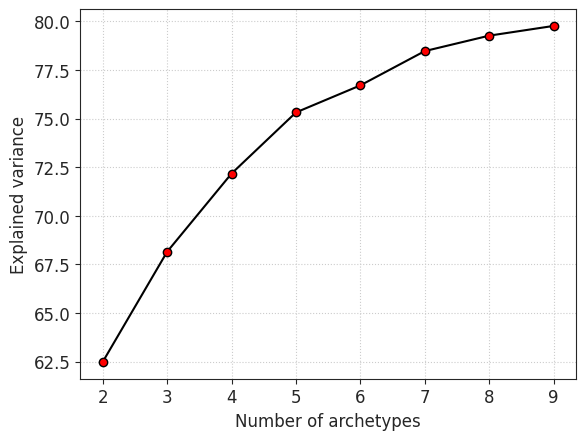

In [75]:
expVars = []
for numArchetypes in allNumArchetypes:
    # Obtain the final results from the outcomes of the individual archetypal analysis on the subsets
    AA = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
                  robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
                  datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)
    expVars.append(AA.explainedVariance_)
plt.plot(allNumArchetypes, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance')
plt.grid(linestyle='dotted')
plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_elbow.png", bbox_inches='tight')

As the elbow occurs when **3** archetypes are used, we refit the data with this value. This also allows comparisons with the previous results from [Benyamin Motevalli](https://researchdata.edu.au/archetypal-analysis-package/1424520) and [Manuel J. A. Eugster](https://www.jstatsoft.org/article/view/v030i08).

In [24]:
numArchetypes, numSubset = 3, 3
AA = runPIAA2(Xscaled, numArchetypes=numArchetypes, numSubset=numSubset, onlyZ=False,
              robust=ROBUST, shuffle=SHUFFLE, randomState=RANDOM_STATE, 
              datasetType=f"{figNamePrefix}{numSubset}S", verbose=VERBOSE, splitRunTime=splitRunTime)

  Subset: skeletonPIAA3Soutput1.pkl
  Subset: skeletonPIAA3Soutput2.pkl
  Subset: skeletonPIAA3Soutput3.pkl
RSS FISTA = 169.82203
RSS FISTA = 147.8388
RSS FISTA = 144.96946
RSS AS = 143.70109
RSS AS = 143.45762
RSS AS = 143.39786
RSS AS = 143.37886
RSS AS = 143.3713
RSS AS = 143.36802
RSS AS = 143.36649
RSS AS = 143.36572
RSS AS = 143.36532
RSS AS = 143.36508
RSS AS = 143.36495
RSS AS = 143.36486
RSS AS = 143.36481
RSS AS = 143.36478
RSS AS = 143.36476
RSS AS = 143.36474
RSS AS = 143.36473
RSS AS = 143.36473
RSS AS = 143.36473
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 143.36472
RSS AS = 14

### Mapping Data to Archetype Space

We can map the data samples to the convex hull formed by the archetypes using simplex plots.

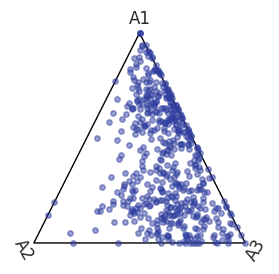

In [34]:
archIDs = list(range(AA.nArchetypes))
AA.plotSimplex(AA.alfa, archIDs, figSize=(3, 3), markerSize=15, figNamePrefix=figNamePrefix)

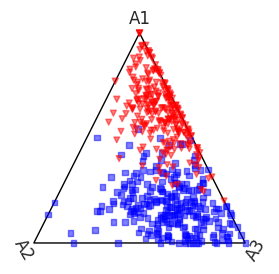

In [35]:
# Users have the flexibility to assign attributes (marker color, marker shape, marker size) to the data samples to enrich the plot.
dfArgs = df[['Gender']].copy()
dfArgs.loc[:, 'color'] = 'red'
dfArgs.loc[dfArgs['Gender']=='female', 'color'] = 'blue'

dfArgs.loc[:, 'marker'] = 'v'
dfArgs.loc[dfArgs['Gender']=='female', 'marker'] = 's'

dfArgs.loc[:, 'size'] = df[['Height']] / 10

plotArgs = {'color': dfArgs['color'], 's': dfArgs['size'], 'marker': dfArgs['marker']}

AA.plotSimplex(AA.alfa, archIDs, plotArgs, figSize=(3, 3), figNamePrefix=f"{figNamePrefix}_markGender")

Additional utility functions are included to allow more flexibities to create simplex plots and color the data points in different fashions. This requires three steps:
1. Create the simplex plot frame with **create_simplex_ax** utility function.
2. Map the **.alfa** values to the simplex frame using the **map_alfa_to_simplex** utility function.
3. Use standard matplotlib scatter plot to visualise data points.

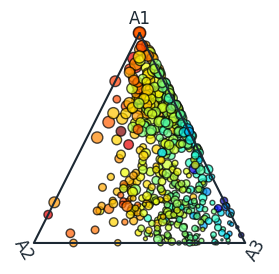

In [58]:
# STEP 1: Create the simplex plot. Users can control the color of gridlines and borders (edges) of the simplex plots. 
createSimplexAx(AA, gridOn=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', figSize=(3, 3))
# STEP 2: Map the alfa values to simplex plot.
mappedAlfa = mapAlfaToSimplex(AA.alfa, AA)
# STEP 3: Use scatter plots to add the mapped alfa to simplex frame.
# The data points are colored by 'Biil' attribute, while sizes are correlated to normalised 'ChestDiam'.
df['ChestDiamNorm'] = (df['ChestDiam'] - df['ChestDiam'].min()) / (df['ChestDiam'].max() - df['ChestDiam'].min())
plt.scatter(mappedAlfa[:,0], mappedAlfa[:,1], 
            c=df['Biil'], cmap='jet', edgecolor='k', 
            s=df['ChestDiamNorm'] * 80, alpha=0.7);
plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_SizeColour_simplex.png", bbox_inches='tight')

Any other point (e.g. prototypes of clusters) can also be mapped to the simplex plot to compare their relative locations (with other points provided or the overall dataset).

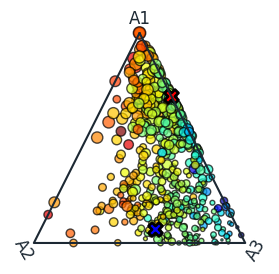

In [59]:
# STEP 1: Get the alpha values for males and females.
XavgMale = Xscaled[df['Gender'] == 'male'].mean(axis=0).reshape(1, -1)
XavgFemale = Xscaled[df['Gender'] == 'female'].mean(axis=0).reshape(1, -1)
_, alfaMale = AA.transform(XavgMale)
_, alfaFemale = AA.transform(XavgFemale)

# STEP 2: Create the simplex plot.
createSimplexAx(AA, gridOn=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', figSize=(3, 3))

# STEP 3: Map the alphas values to the plot.
mappedAlfa = mapAlfaToSimplex(AA.alfa, AA)
mappedAlfaMale = mapAlfaToSimplex(alfaMale, AA)
mappedAlfaFemale = mapAlfaToSimplex(alfaFemale, AA)

# STEP 4: Plot the data samples.
df['ChestDiamNorm'] = (df['ChestDiam']-df['ChestDiam'].min()) / (df['ChestDiam'].max()-df['ChestDiam'].min())
plt.scatter(mappedAlfa[:, 0], mappedAlfa[:, 1], c=df['Biil'], cmap='jet', edgecolor='k', s=df['ChestDiamNorm'] * 80, alpha=0.7);
plt.scatter(mappedAlfaMale[:, 0], mappedAlfaMale[:, 1], marker='X', s=100, color='r', edgecolor='k', linewidth=2);
plt.scatter(mappedAlfaFemale[:, 0], mappedAlfaFemale[:, 1], marker='X', s=100, color='b', edgecolor='k', linewidth=2);
plt.savefig(f"{FIGS_DIR_PATH}/{figNamePrefix}_markPrototype_simplex.png", bbox_inches='tight')

### Visualising Archetype Profiles

The profile of the archetypes can be plot as bar plots or radar plots.

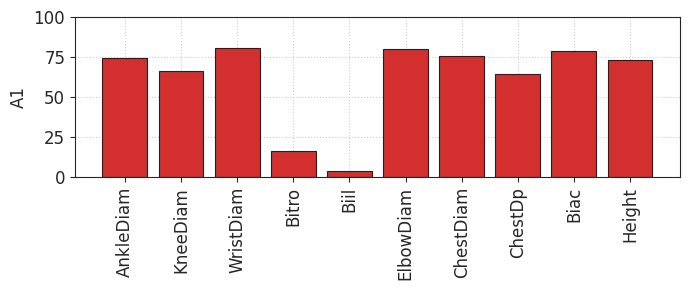

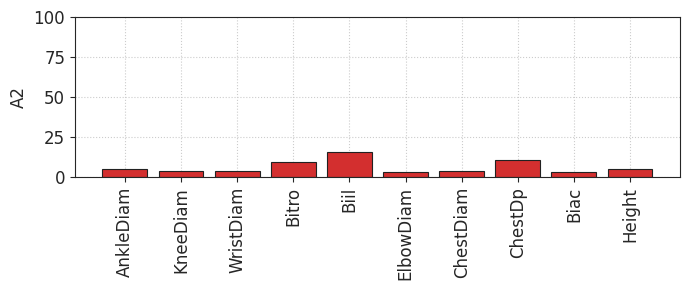

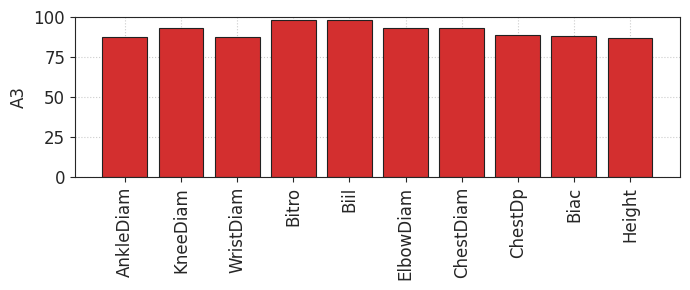

In [82]:
featIDs = range(len(featNames))
AA.plotProfile(featNames, featIDs, archIDs, figSize=(7, 3), figNamePrefix=figNamePrefix)

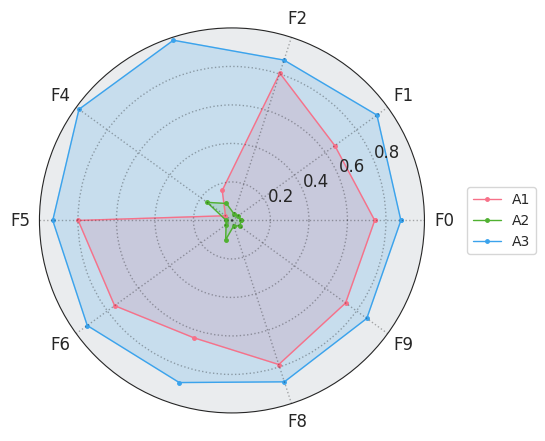

In [83]:
AA.plotRadarProfile(featNames, featIDs, archIDs, sepArchs=False, showLabel=True, figSize=(5, 5), figNamePrefix=figNamePrefix)

### Identifying Most Archetypal Data Samples

The most archetypal data samples could be identified by running **._extractCloseMatch()** on the **ArchetypalAnalysis()** object.

Regarding the **.closeMatch** object:
- The keys are the archetypes.
- The first item in the tuple gives the index of the most archetypal data sample.
- The second item is the corresponding $\alpha$ array of that data point.

The data samples can be mapped to a simplex plot or displayed on a radar plot.

In [84]:
AA._extractCloseMatch()
AA.closeMatch

{1: (109, array([0.76479943, 0.09884301, 0.13635756])),
 2: (249, array([0.        , 0.92027823, 0.07972177])),
 3: (144, array([0.10426882, 0.01347575, 0.88225544]))}

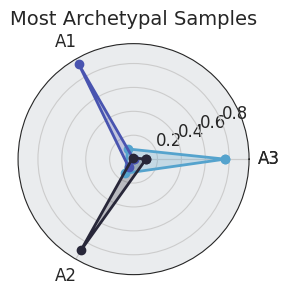

In [85]:
# Radar plot of the most archetypal data samples in the archetype space
archIDs = [0, 42, 77]
AA.plotCloseMatch(archIDs, title='Most Archetypal Samples', figNamePrefix=figNamePrefix)

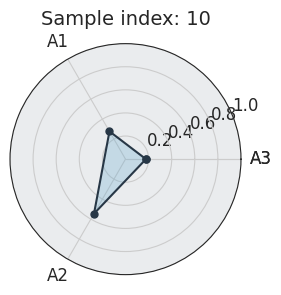

In [86]:
# Any data sample in the archetype space can also be plotted
idxs = [10]
ax = plotRadarDatapoints(AA, Xscaled, sampIDs=idxs, title=f"Sample index: {idx}", figNamePrefix=figNamePrefix)

### Visualing Most Archetypal Samples on 2D Embedding Space from Manifold Learning

The most archetypal data samples can also be marked out on the 2D embedding space obtained from manifold learning (*t*-SNE in our case).

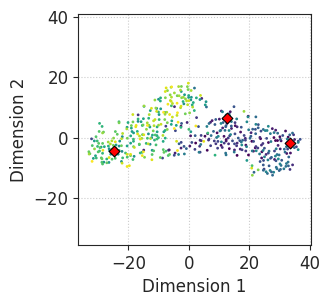

In [87]:
closestSampleIdxs = [sampleIdx for (sampleIdx, archetype) in AA.closeMatch.values()]
plotTSNE(Xscaled, figNamePrefix=figNamePrefix, markIdxs=closestSampleIdxs)

### Visualing Samples and Archetypes on Parallel Axis

The data samples and archetypes could also be plotted on a parallel axis.

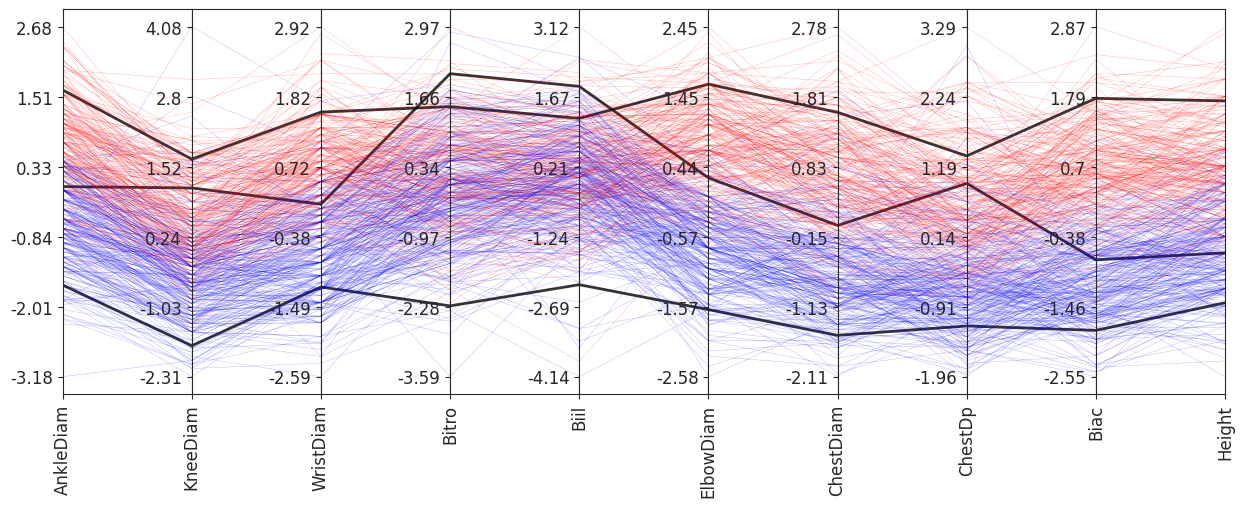

In [82]:
AA.parallelPlot(featNames, dfArgs[['color']].copy(), 
                linewidth='0.3', archColor='k', figNamePrefix=figNamePrefix)